In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy.optimize as sciopt
import scipy.stats as stats
import pandas as pd

data = pd.read_csv('../results/dose_response_params_09252023.csv')
g_drugless = data['g_drugless']
ic50_est = data['ic50']
mut_list = data['n_mut']

gr_lib = pd.read_csv('../results/gr_lib.csv',index_col=0)
gr_err_lib = pd.read_csv('../results/gr_err_lib.csv',index_col=0)

def int_to_binary(num,n_genotype=16):
    """
    Converts an integer to binary representation with the number of 
    digits equal to the number of alleles in the model.

    Parameters
    ----------
    num : int
        Number to be converted.

    Returns
    -------
    str
        Binary representation.

    """
    pad = int(np.log2(n_genotype))
    return bin(num)[2:].zfill(pad)

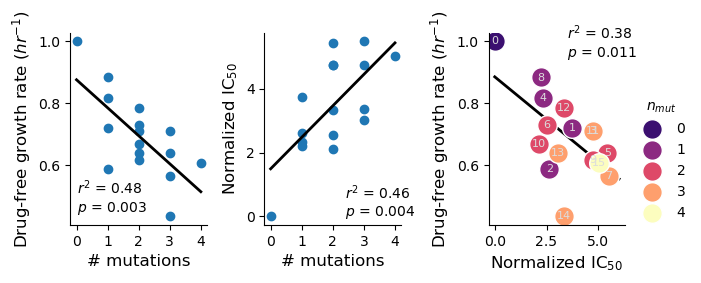

In [3]:
fig,ax_list = plt.subplots(ncols=3,figsize=(6,2.5))

g_drugless = np.array(g_drugless)
g_norm = g_drugless/g_drugless[0]

ax = ax_list[0]

ax.plot(mut_list,g_norm,'o')

res = stats.linregress(mut_list,g_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax = ax_list[1]

ic50_norm = ic50_est - ic50_est[0]

ax.plot(mut_list,ic50_norm,'o')

res = stats.linregress(mut_list,ic50_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(2.4,0),fontsize=10)

ax = ax_list[2]

cmap = cm.get_cmap('magma',6)
cmap = cmap.colors

mut_v_gr = [[],[],[],[],[]]

ic50_norm = ic50_est - ic50_est[0]

for key in data.index:

    ic50 = ic50_norm[int(key)]
    g = g_norm[int(key)]

    # key_bin = int(key)

    num = mut_list[int(key)]

    mut_v_gr[num].append(g_drugless)

    ax.scatter(ic50,g,marker='o',s=200,facecolor=cmap[num+1],
                edgecolors='w',label=int(num))
    # ax4.annotate(key,(ic50-0.15,g_drugless-0.001),fontsize=12)
    ax.annotate(key,(ic50,g),fontsize=8,ha='center',va='center',color='gainsboro')
    

# ax.set_ylim(0.06,0.115)
# ax.set_xlim(-3,4)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.set_xlabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

handles, labels = ax.get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax.legend(unique_handles,unique_labels,loc = (1.05,0),frameon=False,
             fontsize=10,title='$n_{mut}$')

res = stats.linregress(ic50_norm,g_norm)

xfit = np.arange(0,7)
yfit = res.slope*xfit + res.intercept

ax.plot(xfit,yfit,color='k',linewidth=2,zorder=0)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(3.5,0.95),fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# labels = ['A','B','C']

# indx = 0
# for ax in ax_list:
#     pos = ax.get_position()
#     pos.x0 = pos.x0 + 0.04*indx
#     pos.x1 = pos.x1 + 0.04*indx
#     ax.set_position(pos)

#     # ax.annotate(labels[indx],(-0.1,1.06),fontsize=12,xycoords='axes fraction')

#     indx += 1

pos = ax_list[1].get_position()
pos.x0 += 0.05
pos.x1 += 0.05
ax_list[1].set_position(pos)

pos = ax_list[2].get_position()
pos.x0 += 0.15
pos.x1 += 0.15
ax_list[2].set_position(pos)

# fig.tight_layout()
fig.savefig('../figures/gr_vs_ic50_regression.pdf',bbox_inches='tight')
fig.savefig('../figures/gr_vs_ic50_regression.png',bbox_inches='tight',dpi=300)

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_5021/3330455364.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


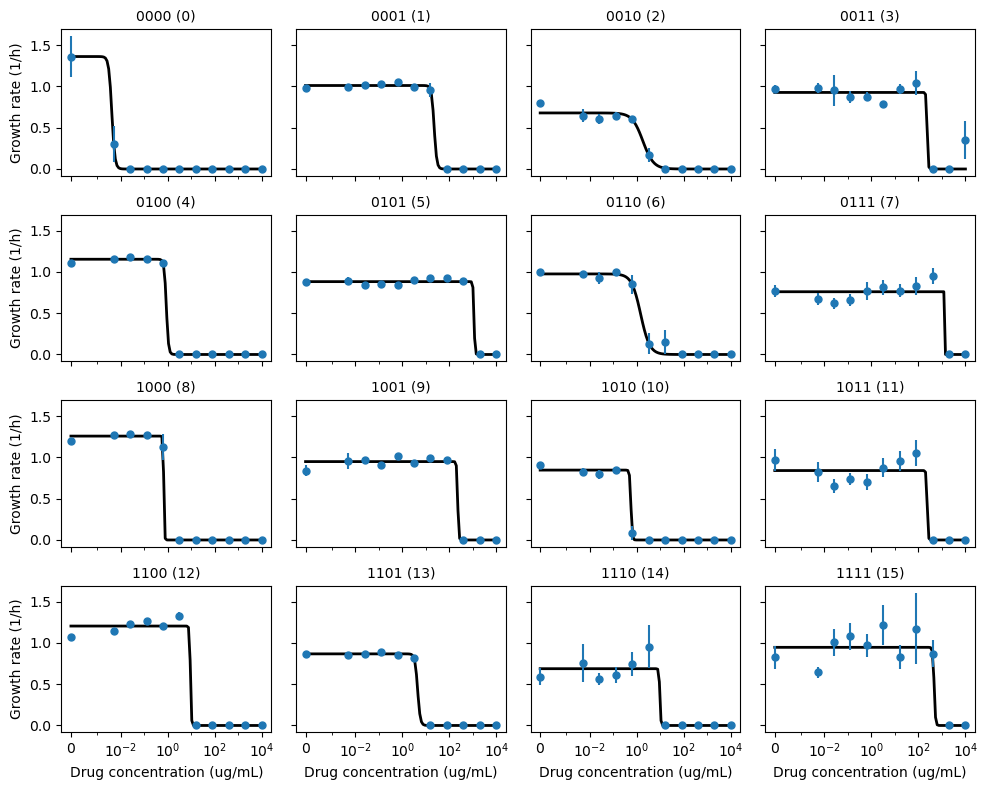

In [4]:
def hill_fn(conc,gmax, hc, ic_50):
    y = []
    gmin = 0
    for c in conc:
        if c == 0:
            y.append(gmax)
        else:
            y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))
    return y

fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(10,8),sharex=True,sharey=True)
ax_list_matrix = ax_list
ax_list = ax_list.flatten()

g_drugless = np.zeros(16)

mic_est = []

seascape_lib = {}

# drug_conc = np.array(gr_lib['drug_conc'])
drug_conc = list(gr_lib['drug_conc'])
drug_conc = [float(i) for i in drug_conc if i != 'control']

for key in np.arange(16):
    y = np.array(gr_lib[str(key)])
    y = y[0:-1]
    x = np.argwhere(y<0.5)
    mic = drug_conc[x[-1][0]]
    mic_est.append(mic)

for i in range(16):
    
    gr_v_dc = np.array(gr_lib[str(i)])
    gr_v_dc_err = np.array(gr_err_lib[str(i)])

    ic50_est = np.log10(np.array(mic_est[i]).astype(float))

    p0 = [gr_v_dc[-2],-0.1,ic50_est]
    # bounds = [[gr_v_dc[-2]-0.1,-10,ic50_est-2],[gr_v_dc[-2]+0.1,0,ic50_est+2]]
    bounds = [[0,-10,ic50_est-2],[2,0,ic50_est+2]]

    gr_v_dc_err_t = np.array(gr_v_dc_err) + 1

    popt,pcov = sciopt.curve_fit(hill_fn,drug_conc,gr_v_dc[0:-1],
                                p0=p0,maxfev=100000,bounds=bounds,
                                sigma=gr_v_dc_err_t[0:-1],absolute_sigma=False)
    
    xfit = np.logspace(-3,4,100)
    xfit = np.concatenate(([0],xfit))

    yfit = hill_fn(xfit,*popt)

    ax = ax_list[i]
    ax.plot(xfit,yfit,color='k',linewidth=2)

    ax.errorbar(drug_conc,gr_v_dc[0:-1],yerr=gr_v_dc_err[0:-1],
                fmt='o',markersize=5)
    
    ax.set_xscale('symlog',linthresh=10**-3)
    ax.set_title(int_to_binary(i) + ' (' + str(i) + ')',fontsize=10)
    # ax.set_yscale('log')
    g_drugless[i] = gr_v_dc[-2]

    param_dict = {'gmax':popt[0],'hc':popt[1],'ic50':popt[2]}
    seascape_lib[i] = param_dict

ax = ax_list[-1]
ax.set_xticks([0,10**-2,1,10**2,10**4]);

for ax in ax_list_matrix[-1,:]:
    ax.set_xlabel('Drug concentration (ug/mL)')

for ax in ax_list_matrix[:,0]:
    ax.set_ylabel('Growth rate (1/h)')

# ax_list_matrix[0,0].annotate('A',(-0.1,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

fig.savefig('../figures/dose_response_curves.pdf',bbox_inches='tight')

In [5]:
for key in seascape_lib.keys():
    
    print(seascape_lib[key]['gmax'])

1.3627516148594752
1.011627398527865
0.679218531814306
0.9276039605212165
1.1542428009477281
0.8828861252972227
0.9762377495433847
0.7604102428839906
1.2589608057529342
0.9499524057378106
0.8469659806901234
0.8413912922091511
1.20490508375268
0.8677695037064365
0.6880990889576407
0.9470095681626043


In [6]:
def gen_neighbors(genotype,n_allele=4):
    mut = range(n_allele)
    neighbors = [genotype ^ (1 << m) for m in mut]

    return neighbors

diff_dict = {}
diff_dict_rel = {} # relative to the wt

ic50_diff_dict = {}

for allele in [0,1,2,3]:
    # generate each genotype contaiing the allele
    contains_allele = []
    excludes_allele = []
    for i in range(16):
        if int_to_binary(i)[3-allele] == '1':
            contains_allele.append(i)
        else:
            excludes_allele.append(i)
    
    diff = []
    ic50_diff = []
    for g in contains_allele:
        neighbors = gen_neighbors(g)
        # find the neighbors that do not contain the allele
        neighbors = [n for n in neighbors if n in excludes_allele]

        cur_fit = g_drugless[g]
        cur_ic50 = ic50_norm[g]

        neighbor_fit = g_drugless[neighbors[0]]
        neighbor_ic50 = ic50_norm[neighbors[0]]

        diff.append(cur_fit - neighbor_fit)
        ic50_diff.append(cur_ic50 - neighbor_ic50)

    diff_dict[allele] = diff
    diff_dict_rel[allele] = [g_drugless[i]-g_drugless[0] for i in contains_allele]
    ic50_diff_dict[allele] = ic50_diff
    

/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


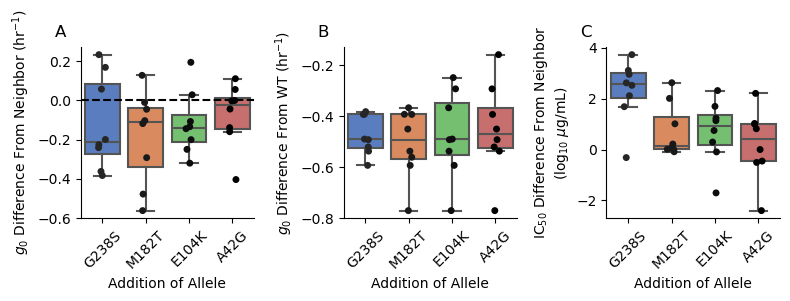

In [7]:
import seaborn as sns

fig,ax_list = plt.subplots(ncols=3,figsize=(8,3))

ax = ax_list[0]
sns.boxplot(data=pd.DataFrame(diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('$g_{0}$ Difference From Neighbor (hr$^{-1}$)')
ax.set_xlabel('Addition of Allele')

ax.plot([-1,4],[0,0],'k--')

ax.set_xlim(-0.5,3.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[1]

sns.boxplot(data=pd.DataFrame(diff_dict_rel),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict_rel),ax=ax,color='k',size=5)

ax.set_ylabel('$g_{0}$ Difference From WT (hr$^{-1}$)')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[2]

sns.boxplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('IC$_{50}$ Difference From Neighbor \n(log$_{10}$ $\mu$g/mL)')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ax in ax_list:
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['G238S','M182T','E104K','A42G'],rotation=45)

labels = ['A','B','C']
for i,ax in enumerate(ax_list):
    ax.annotate(labels[i],(-0.15,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

# make sure the right axis is the same width as the left
pos = ax_list[0].get_position()
pos2 = ax_list[2].get_position()
width = pos.width
pos2.x1 = pos2.x0 + width
ax_list[2].set_position(pos2)


fig.savefig('../figures/allele_fitness_diff.pdf',bbox_inches='tight')

In [8]:
# pairwise t-test for ic50 differences

for i in range(4):
    for j in range(i+1,4):
        print('Allele',i,'vs Allele',j)
        pval = stats.ttest_ind(ic50_diff_dict[i],ic50_diff_dict[j],equal_var=False).pvalue
        print('p-value:',pval)

Allele 0 vs Allele 1
p-value: 0.015969841742729217
Allele 0 vs Allele 2
p-value: 0.021012972874545205
Allele 0 vs Allele 3
p-value: 0.006602898571933559
Allele 1 vs Allele 2
p-value: 0.9596643010990291
Allele 1 vs Allele 3
p-value: 0.41204735692886074
Allele 2 vs Allele 3
p-value: 0.4662747714292861


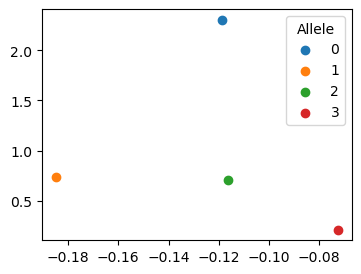

In [9]:
fig,ax = plt.subplots(figsize=(4,3))

for key in diff_dict.keys():

    diff = np.mean(diff_dict[key])
    ic_50 = np.mean(ic50_diff_dict[key])


    ax.scatter(diff,ic_50,label=key)

ax.legend(title='Allele',fontsize=10)

In [10]:
import statsmodels.api as sm

data = pd.DataFrame(columns=['g0','ic50','G238S','M182T','E104K','A42G'])

for i in range(16):
    data.loc[i] = [g_drugless[i],ic50_norm[i],0,0,0,0]
    for j in range(4):
        if int_to_binary(i)[3-j] == '1':
            data.loc[i][j+2] = 1

formula = 'g0 ~ G238S + M182T + E104K + A42G + G238S:M182T + G238S:E104K + G238S:A42G + M182T:E104K + M182T:A42G + E104K:A42G'

model = sm.OLS.from_formula(formula,data=data)

result_gr = model.fit()

print(result_gr.summary())

formula = 'ic50 ~ G238S + M182T + E104K + A42G + G238S:M182T + G238S:E104K + G238S:A42G + M182T:E104K + M182T:A42G + E104K:A42G'

model = sm.OLS.from_formula(formula,data=data)

result_ic50 = model.fit()

print(result_ic50.summary())

                            OLS Regression Results                            
Dep. Variable:                     g0   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 17 May 2024   Prob (F-statistic):              0.203
Time:                        11:18:37   Log-Likelihood:                 18.382
No. Observations:                  16   AIC:                            -14.76
Df Residuals:                       5   BIC:                            -6.266
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3062      0.114     11.481      

/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)


/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_5021/2513791304.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')


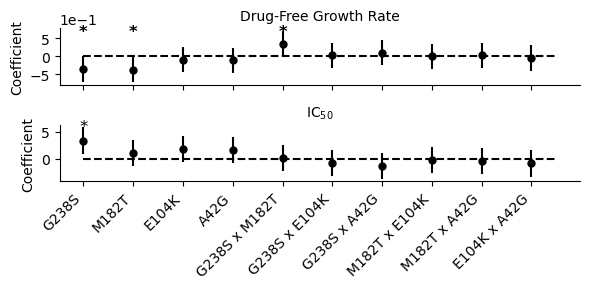

In [11]:
# fig,ax_list = plt.subplots(ncols=2,figsize=(6,4),sharey=True)
fig,ax_list = plt.subplots(nrows=2,figsize=(6,3),sharex=True)

# make a coefficient plot

coeffs = result_ic50.params[1:]
conf_int = result_ic50.conf_int(alpha=0.05)[1:]

ax = ax_list[1]

ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# star the significant coefficients
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,6),fontsize=12,ha='center',va='center')

# ax.set_xlabel('Coefficient')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('IC$_{50}$',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

ax = ax_list[0]

coeffs = result_gr.params[1:]
conf_int = result_gr.conf_int(alpha=0.05)[1:]

# ax.errorbar(coeffs,coeffs.index,xerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
#             fmt='o',color='k',markersize=5)
ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# make y axis scientific notation
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,0.7),fontsize=12,ha='center',va='center',fontweight='bold')

# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Drug-Free Growth Rate',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

# align ticklabels to the right

xl = ['E104K x A42G','M182T x A42G','M182T x E104K','G238S x A42G','G238S x E104K','G238S x M182T','A42G','E104K','M182T','G238S']
# reverse yl
xl = xl[::-1]
ax = ax_list[1]

ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

# for x in xl:
#     x.set_horizontalalignment("right")
for ax in ax_list:
    ax.plot([0,9.5],[0,0],'k--')

# ax_list[0].annotate('D',(-0.05,1.06),fontsize=12,xycoords='axes fraction')
# ax_list[1].annotate('E',(-0.05,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()
fig.savefig('../figures/allele_mlr_coefficients.pdf',bbox_inches='tight')

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_5021/1991712573.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')
/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_5021/1991712573.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')


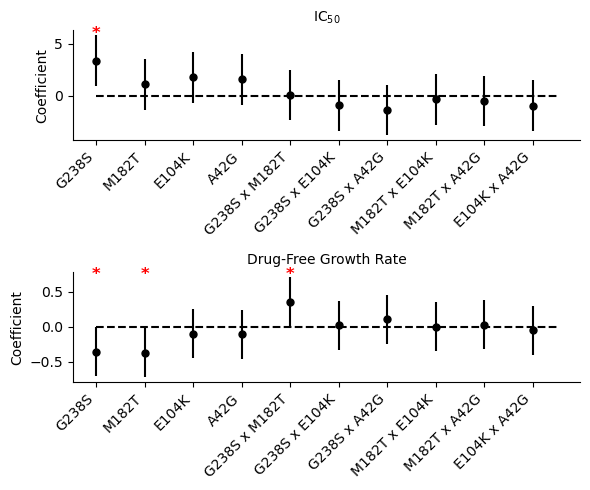

In [12]:
# fig,ax_list = plt.subplots(ncols=2,figsize=(6,4),sharey=True)
fig,ax_list = plt.subplots(nrows=2,figsize=(6,5))

# make a coefficient plot

coeffs = result_ic50.params[1:]
conf_int = result_ic50.conf_int(alpha=0.05)[1:]

ax = ax_list[0]

ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# star the significant coefficients
for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,6),fontsize=12,ha='center',va='center',
                    fontweight='bold',color='red')

# ax.set_xlabel('Coefficient')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('IC$_{50}$',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

ax = ax_list[1]

coeffs = result_gr.params[1:]
conf_int = result_gr.conf_int(alpha=0.05)[1:]

# ax.errorbar(coeffs,coeffs.index,xerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
#             fmt='o',color='k',markersize=5)
ax.errorbar(coeffs.index,coeffs,yerr=[coeffs-conf_int[0],conf_int[1]-coeffs],
            fmt='o',color='k',markersize=5)

ax.set_ylabel('Coefficient')

# make y axis scientific notation
# ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for i in range(len(coeffs)):
    if conf_int[0][i] > 0 or conf_int[1][i] < 0:
        ax.annotate('*',xy=(i,0.75),fontsize=12,ha='center',va='center',
                    fontweight='bold',color='red')

# ax.set_xlabel('Coefficient')
# ax.set_ylabel('Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Drug-Free Growth Rate',fontsize=10)

# ax.plot([0,0],[0,9.5],'k--')

# align ticklabels to the right

xl = ['E104K x A42G','M182T x A42G','M182T x E104K','G238S x A42G','G238S x E104K','G238S x M182T','A42G','E104K','M182T','G238S']
# reverse yl
xl = xl[::-1]
ax = ax_list[1]

ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

ax = ax_list[0]
ax.set_xticklabels(xl,rotation=45,fontsize=10,ha='right')

# for x in xl:
#     x.set_horizontalalignment("right")
for ax in ax_list:
    ax.plot([0,9.5],[0,0],'k--')

# ax_list[0].annotate('D',(-0.05,1.06),fontsize=12,xycoords='axes fraction')
# ax_list[1].annotate('E',(-0.05,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()
fig.savefig('../figures/allele_mlr_coefficients_tall.png',bbox_inches='tight',dpi=500)
# fig.savefig('../figures/allele_mlr_coefficients.pdf',bbox_inches='tight')